# Inferring Transportation Modes via Clustering

Goal: infer likely transportation modes (road, rail, sea, air) using available telemetry by combining features like fuel consumption, GPS-derived speed, congestion/port/customs impacts, and costs. This notebook:

1) Loads data and shows basic missing-value stats (no modifications yet)
2) Builds features (incl. approximate speed from GPS/time)
3) Applies light imputation (time-series interpolation + categorical mode)
4) Runs clustering (KMeans with silhouette-based k selection)
5) Heuristically labels clusters as modes and visualizes
6) Exports dataset with `cluster_id` and `inferred_mode`


In [19]:
# Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

DATA_PATH = 'dynamic_supply_chain_logistics_dataset.csv'
assert os.path.exists(DATA_PATH), f"CSV not found at {DATA_PATH}"

na_tokens = ['', ' ', 'na', 'n/a', 'NA', 'N/A', 'null', 'NULL', 'none', 'None', 'nan', 'NaN', 'NAN', '-', '--']

df = pd.read_csv(DATA_PATH, na_values=na_tokens, keep_default_na=True, low_memory=False)
print('Rows, Cols:', df.shape)
df.head(3)


Rows, Cols: (32065, 26)


,timestamp,vehicle_gps_latitude,vehicle_gps_longitude,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,supplier_reliability_score,lead_time_days,historical_demand,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,2021-01-01 00:00:00,40.375568,-77.014318,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,0.359066,4.289160,456.503853,0.986064,2.128009,100.772854,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,2021-01-01 01:00:00,33.507818,-117.036902,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,0.230660,7.018373,640.408205,0.463233,12.608166,5313.738114,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,2021-01-01 02:00:00,30.020640,-75.269224,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,0.027210,9.605064,155.749314,0.598561,14.124452,1595.049146,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594


In [20]:
# Missing stats (no changes)
na_counts = df.isna().sum()
na_pct = (na_counts / len(df) * 100).round(3)
missing_summary = (
    pd.DataFrame({'dtype': df.dtypes.astype(str), 'missing_count': na_counts, 'missing_pct': na_pct})
    .sort_values('missing_pct', ascending=False)
)
missing_summary


,dtype,missing_count,missing_pct
timestamp,object,0,0.0
vehicle_gps_latitude,float64,0,0.0
risk_classification,object,0,0.0
delay_probability,float64,0,0.0
disruption_likelihood_score,float64,0,0.0
fatigue_monitoring_score,float64,0,0.0
driver_behavior_score,float64,0,0.0
customs_clearance_time,float64,0,0.0
route_risk_level,float64,0,0.0
cargo_condition_status,float64,0,0.0


In [21]:
# Feature engineering: timestamp, speed, and domain features
_df = df.copy()
_df['timestamp'] = pd.to_datetime(_df['timestamp'], errors='coerce')
_df = _df.sort_values('timestamp')

# Approx distance between consecutive points (Haversine in km)
R = 6371.0
lat = np.deg2rad(_df['vehicle_gps_latitude'].astype(float))
lon = np.deg2rad(_df['vehicle_gps_longitude'].astype(float))

dlat = lat.diff()
dlon = lon.diff()
a = np.sin(dlat/2)**2 + np.cos(lat.shift()) * np.cos(lat) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
dist_km = R * c

# Time delta in hours
_dt = _df['timestamp'].diff().dt.total_seconds() / 3600.0
speed_kmh = (dist_km / _dt).replace([np.inf, -np.inf], np.nan)

_df['speed_kmh'] = speed_kmh

# Select features likely informative for mode
feature_cols = [
    'speed_kmh',
    'fuel_consumption_rate',
    'traffic_congestion_level',
    'port_congestion_level',
    'customs_clearance_time',
    'shipping_costs',
    'lead_time_days',
]

X = _df[feature_cols]


In [22]:
# Light imputation for features used in clustering
X_impute = X.copy()
X_impute = X_impute.interpolate(limit_direction='both').ffill().bfill()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_impute)

print('NA remaining in features:', int(pd.DataFrame(X_scaled).isna().sum().sum()))


NA remaining in features: 0


In [23]:
# Silhouette-guided K selection
k_range = range(2, 9)
scores = {}
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores[k] = score

scores_df = pd.DataFrame({'k': list(scores.keys()), 'silhouette': list(scores.values())}).sort_values('k')
scores_df


,k,silhouette
0,2,0.132805
1,3,0.134005
2,4,0.122966
3,5,0.129208
4,6,0.119980
5,7,0.124425
6,8,0.113913


In [24]:
# Fit final model with best k
best_k = max(scores, key=scores.get)
km = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
cluster_labels = km.fit_predict(X_scaled)

_df['cluster_id'] = cluster_labels
print('Best k:', best_k)
_df[['cluster_id'] + feature_cols].head()


Best k: 3


,cluster_id,speed_kmh,fuel_consumption_rate,traffic_congestion_level,port_congestion_level,customs_clearance_time,shipping_costs,lead_time_days
0,2,NaN,5.136512,5.927586,4.289160,0.502006,456.503853,2.128009
1,0,3605.981456,5.101512,1.591992,7.018373,0.966774,640.408205,12.608166
2,0,3941.376571,5.090803,8.787765,9.605064,0.945627,155.749314,14.124452
3,1,874.789260,8.219558,0.045257,8.899616,4.674035,104.317961,3.818972
4,2,739.402752,5.000075,8.004851,0.061760,3.445429,977.222528,14.001491


In [25]:
# Heuristic labeling of clusters as modes
# Rationale hints:
# - Air: high speed, high lead_time_days is unlikely, customs/port lower; costs high
# - Sea: very low speed, high port/customs, long lead time; lower traffic impact
# - Rail: moderate speed, low congestion, lower customs than sea, medium costs
# - Road: moderate speed, higher traffic impact, shorter customs/port

cluster_profile = _df.groupby('cluster_id')[feature_cols].median()
cluster_profile_ranked = cluster_profile.rank(pct=True)

labels = {}
for cid, row in cluster_profile_ranked.iterrows():
    if row['speed_kmh'] > 0.9 and row['shipping_costs'] > 0.7:
        labels[cid] = 'Air'
    elif row['speed_kmh'] < 0.2 and row['port_congestion_level'] > 0.7 and row['lead_time_days'] > 0.7:
        labels[cid] = 'Sea'
    elif row['traffic_congestion_level'] > 0.6 and row['customs_clearance_time'] < 0.5:
        labels[cid] = 'Road'
    else:
        labels[cid] = 'Rail'

_df['inferred_mode'] = _df['cluster_id'].map(labels)

cluster_profile, labels


(              speed_kmh  fuel_consumption_rate  traffic_congestion_level  port_congestion_level  customs_clearance_time  shipping_costs  lead_time_days
 cluster_id                                                                                                                                             
 0           1967.080040               5.496547                  4.865060               8.926894                1.942709      375.294740       11.859959
 1           1984.596756               5.723103                  4.917547               9.531503                1.953947      390.645629        1.703667
 2           1960.370505               5.651746                  5.202749               2.197407                1.895595      397.504861        2.292623,
 {0: 'Rail', 1: 'Rail', 2: 'Road'})

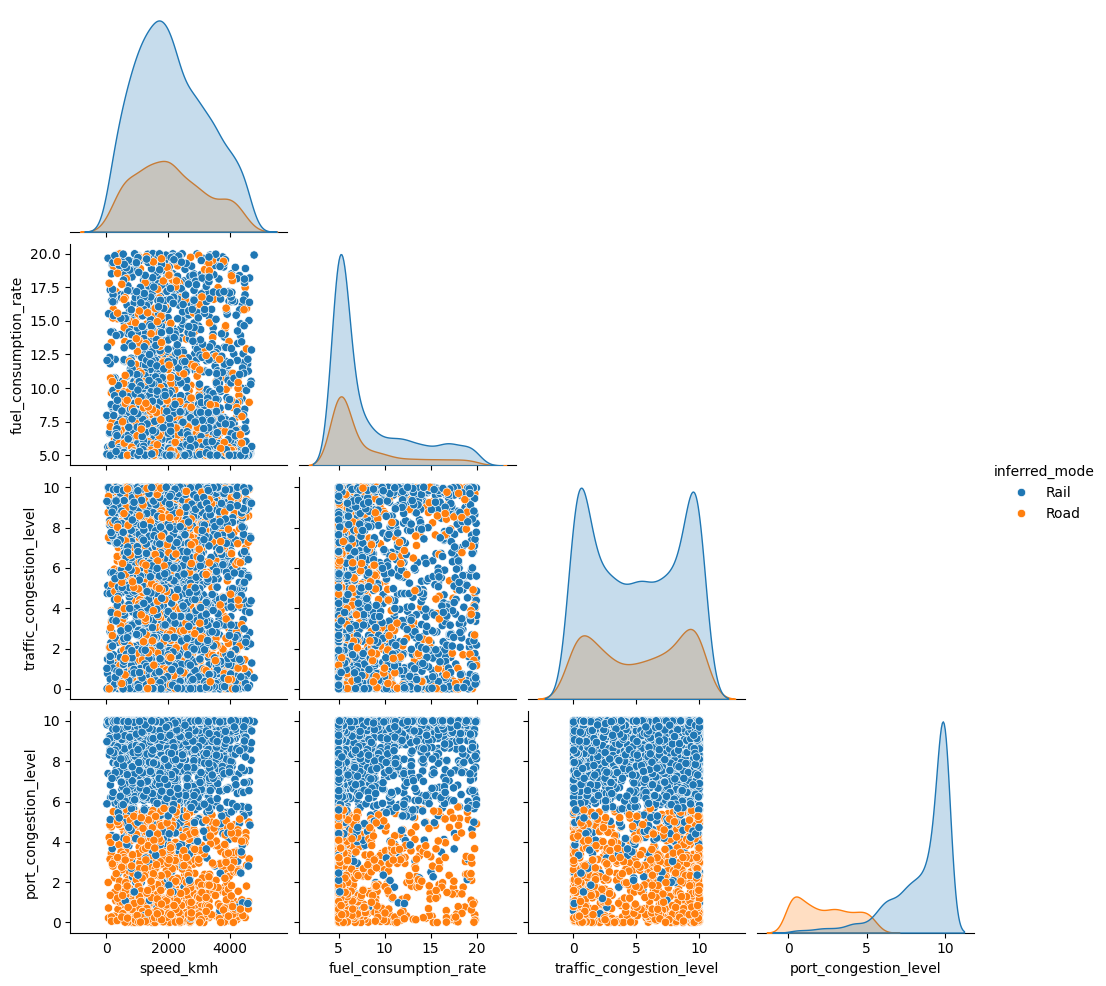

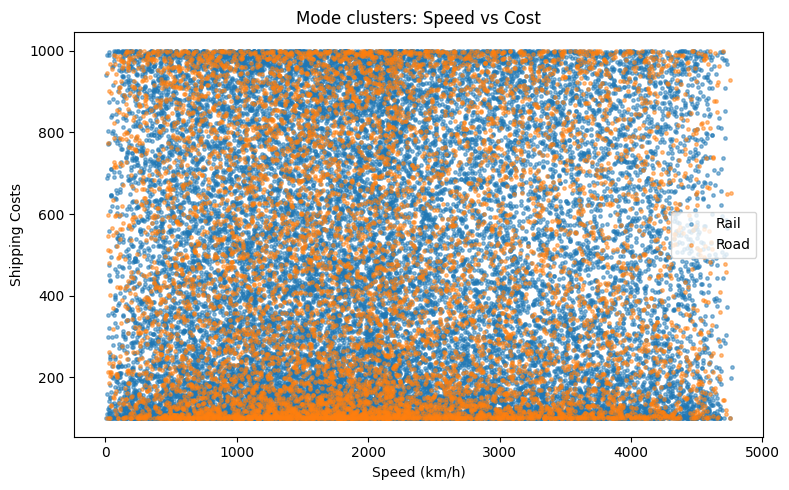

In [26]:
# Visualize clusters in 2D via pairplot and selected projections
sns.pairplot(_df.sample(min(3000, len(_df)), random_state=42), vars=feature_cols[:4], hue='inferred_mode', corner=True)
plt.show()

plt.figure(figsize=(8,5))
for mode, g in _df.groupby('inferred_mode'):
    plt.scatter(g['speed_kmh'], g['shipping_costs'], s=6, label=mode, alpha=0.5)
plt.xlabel('Speed (km/h)')
plt.ylabel('Shipping Costs')
plt.title('Mode clusters: Speed vs Cost')
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
# Export results
OUTPUT_PATH = 'dynamic_supply_chain_with_modes.csv'
export_cols = ['timestamp', 'vehicle_gps_latitude', 'vehicle_gps_longitude'] + feature_cols + ['cluster_id', 'inferred_mode']

export_df = _df[export_cols].copy()
export_df.to_csv(OUTPUT_PATH, index=False)
print('Saved:', OUTPUT_PATH)
print('Rows, Cols:', export_df.shape)


Saved: dynamic_supply_chain_with_modes.csv
Rows, Cols: (32065, 12)


In [28]:
# Expanded feature set configuration
USE_ALL_NUMERIC = True              # if False, use the original base feature set
APPLY_LOG_TRANSFORMS = True         # apply log1p to skewed positive variables
CORR_PRUNE = True                   # drop one of highly correlated features
CORR_THRESHOLD = 0.95
APPLY_PCA = False                   # reduce dimensionality for clustering stability
PCA_COMPONENTS = 10

# Columns to exclude (labels/leakage or identifiers)
EXCLUDE_COLS = set([
    'timestamp',                 # identifier / index
    'risk_classification',       # categorical label
])

# Base feature set from earlier
base_feature_cols = [
    'speed_kmh',
    'fuel_consumption_rate',
    'traffic_congestion_level',
    'port_congestion_level',
    'customs_clearance_time',
    'shipping_costs',
    'lead_time_days',
]

# Build candidate numeric feature set
num_cols_all = _df.select_dtypes(include=[np.number]).columns.tolist()
num_cols_all = [c for c in num_cols_all if c not in EXCLUDE_COLS]

# Ensure engineered speed exists
assert 'speed_kmh' in num_cols_all, 'speed_kmh missing; ensure earlier cell ran.'

# Choose feature set
selected_cols = num_cols_all if USE_ALL_NUMERIC else base_feature_cols
X_full = _df[selected_cols].copy()

# Optional log1p transforms on positive-skew features that are >= 0
if APPLY_LOG_TRANSFORMS:
    log_candidates = []
    for col in selected_cols:
        series = X_full[col]
        if series.min(skipna=True) >= 0 and series.skew(skipna=True) > 1.0:
            log_candidates.append(col)
    for col in log_candidates:
        X_full[col] = np.log1p(X_full[col])
    print('Applied log1p to:', log_candidates)

# Light imputation
X_full = X_full.interpolate(limit_direction='both').ffill().bfill()

# Optional correlation pruning
if CORR_PRUNE and len(selected_cols) > 1:
    corr = X_full.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > CORR_THRESHOLD)]
    kept_cols = [c for c in X_full.columns if c not in to_drop]
    if len(kept_cols) >= max(3, PCA_COMPONENTS):
        X_full = X_full[kept_cols]
        print('Correlation pruning removed:', to_drop)
    else:
        print('Correlation pruning skipped (would remove too many cols).')

# Standardize
scaler_full = StandardScaler()
X_scaled = scaler_full.fit_transform(X_full)
feature_cols = list(X_full.columns)

# Optional PCA
if APPLY_PCA:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=min(PCA_COMPONENTS, X_scaled.shape[1]))
    X_scaled = pca.fit_transform(X_scaled)
    print('PCA applied with components:', X_scaled.shape[1])

print('Expanded feature count:', len(feature_cols))
print('NA remaining in features:', int(pd.DataFrame(X_scaled).isna().sum().sum()))


Applied log1p to: ['fuel_consumption_rate']
Correlation pruning removed: []
Expanded feature count: 26
NA remaining in features: 0


In [29]:
# Recompute clusters using the CURRENT feature matrix (X_scaled, feature_cols)
# Run this cell after changing the expanded-feature flags above
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

assert 'X_scaled' in globals(), 'X_scaled not found. Run the feature prep cell first.'
assert '_df' in globals(), '_df not found. Run earlier cells first.'

# 1) K selection
k_range = range(2, 9)
scores = {}
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores[k] = score

best_k = max(scores, key=scores.get)
print('Silhouette by k:', scores)
print('Selected best_k =', best_k)

# 2) Fit final KMeans
km = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
cluster_labels = km.fit_predict(X_scaled)
_df['cluster_id'] = cluster_labels

# 3) Heuristic labeling (re-uses current feature_cols)
cluster_profile = _df.groupby('cluster_id')[feature_cols].median()
cluster_profile_ranked = cluster_profile.rank(pct=True)

labels = {}
for cid, row in cluster_profile_ranked.iterrows():
    if ('speed_kmh' in row and 'shipping_costs' in row and
        row['speed_kmh'] > 0.9 and row['shipping_costs'] > 0.7):
        labels[cid] = 'Air'
    elif ('speed_kmh' in row and 'port_congestion_level' in row and 'lead_time_days' in row and
          row['speed_kmh'] < 0.2 and row['port_congestion_level'] > 0.7 and row['lead_time_days'] > 0.7):
        labels[cid] = 'Sea'
    elif 'traffic_congestion_level' in row and 'customs_clearance_time' in row and \
         row['traffic_congestion_level'] > 0.6 and row['customs_clearance_time'] < 0.5:
        labels[cid] = 'Road'
    else:
        labels[cid] = 'Rail'

_df['inferred_mode'] = _df['cluster_id'].map(labels)

print('Cluster counts:')
print(_df['cluster_id'].value_counts().sort_index())
print('Mode counts:')
print(_df['inferred_mode'].value_counts())

# 4) Save a new CSV
OUTPUT_PATH = 'dynamic_supply_chain_with_modes_expanded.csv'
export_cols = ['timestamp', 'vehicle_gps_latitude', 'vehicle_gps_longitude'] + list(feature_cols) + ['cluster_id', 'inferred_mode']
_df[export_cols].to_csv(OUTPUT_PATH, index=False)
print('Saved:', OUTPUT_PATH)


Silhouette by k: {2: 0.06353277252342909, 3: 0.05644936900336911, 4: 0.03965197647130517, 5: 0.0374230965662498, 6: 0.03240360724524206, 7: 0.03174746218408572, 8: 0.027693303376322677}
Selected best_k = 2
Cluster counts:
cluster_id
0     8363
1    23702
Name: count, dtype: int64
Mode counts:
inferred_mode
Air     23702
Rail     8363
Name: count, dtype: int64
Saved: dynamic_supply_chain_with_modes_expanded.csv
